In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import poppy

from adefc_vortex.math_module import xp, xcipy, ensure_np_array
from adefc_vortex import utils
from adefc_vortex.imshows import imshow1, imshow2, imshow3, plot_data
from adefc_vortex import dm
from adefc_vortex import props
from adefc_vortex import aefc_1dm as adefc
import adefc_vortex.pwp as pwp
import adefc_vortex.scoob_model as scoobm

wavelength_c = 633e-9
npix = 1000


/opt/conda/envs/km310env/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


# SCoOB Setup Fig

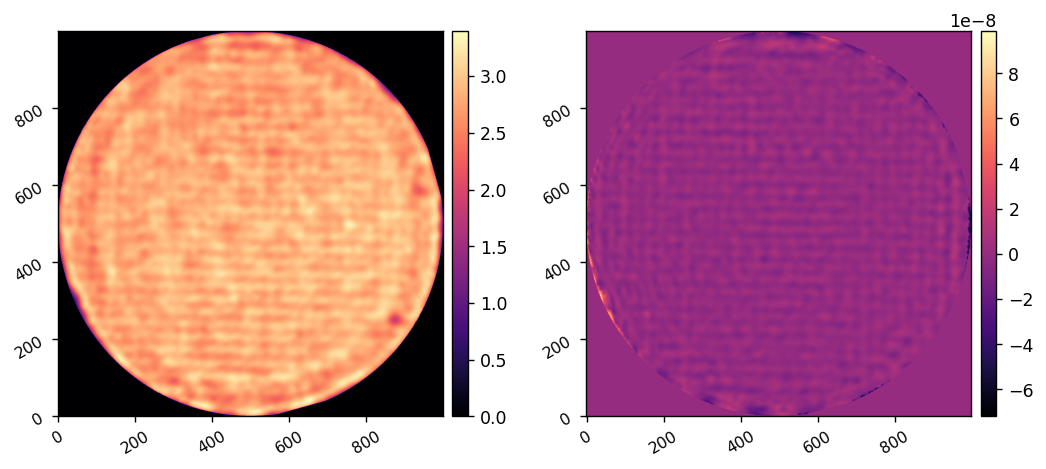

In [3]:

data = utils.load_pickle('data/20250114_fdpr2_ref_processed.pkl')
wfe_amp = data['amp']
wfe_opd = data['opd']
imshow2(wfe_amp, wfe_opd)

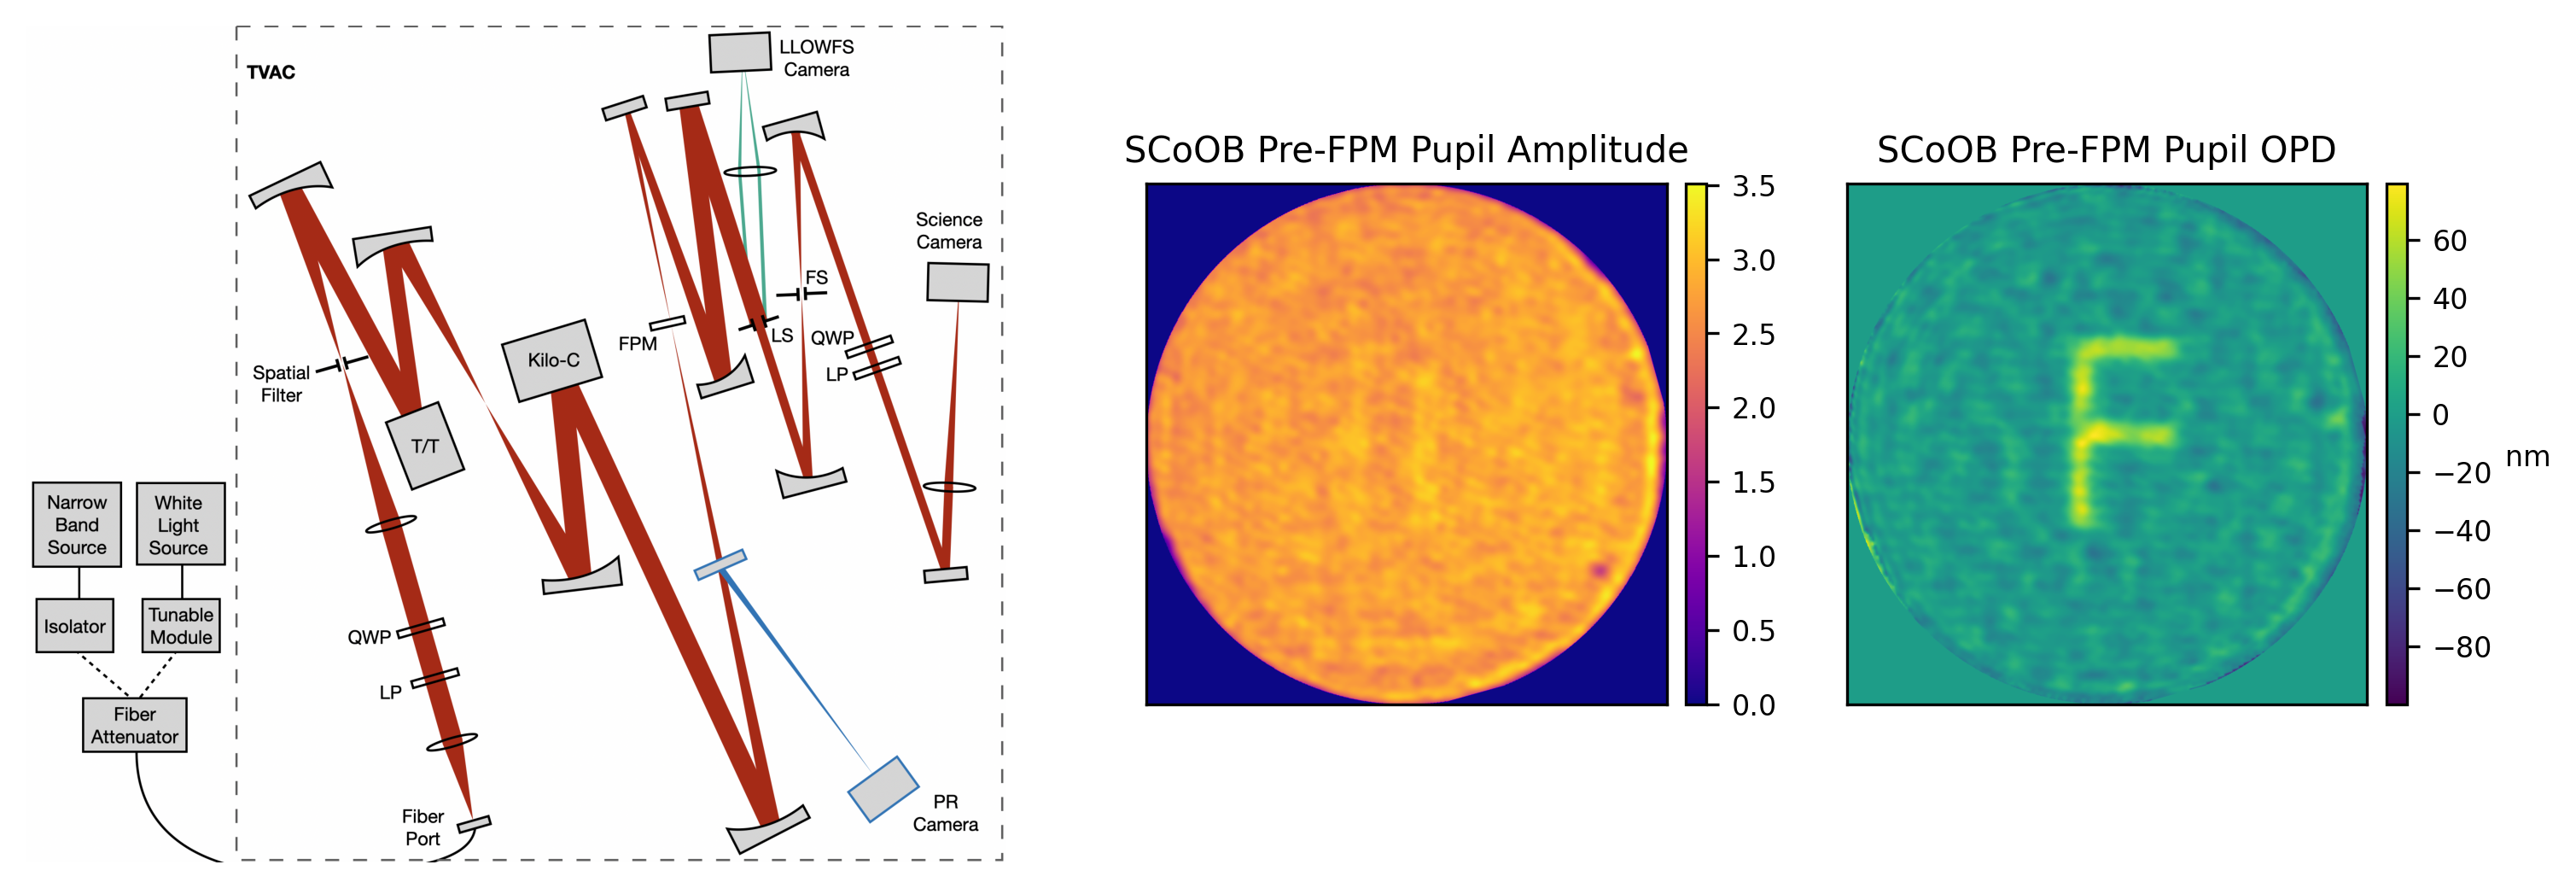

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['image.origin']='lower'
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm, Normalize
from matplotlib.gridspec import GridSpec
# Read the image
# img = np.flipud(mpimg.imread('scoob_diagram.png'))
img = np.flipud(mpimg.imread('scoob_layout.png'))

# Display the image
fig, ax = plt.subplots(nrows=1, ncols=3, dpi=300, figsize=(12,6), gridspec_kw={'width_ratios': [1.75, 1, 1], })
ax[0].imshow(img)
ax[0].axis('off')  # Turn off axis labels and ticks

tfs = 10

im = ax[1].imshow( ensure_np_array(wfe_amp), cmap='plasma')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('SCoOB Pre-FPM Pupil Amplitude', fontsize=tfs)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=8)
# cbar.ax.set_ylabel('m', rotation=0, labelpad=7)

im = ax[2].imshow( ensure_np_array(wfe_opd)*1e9, cmap='viridis')
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('SCoOB Pre-FPM Pupil OPD', fontsize=tfs)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="4%", pad=0.075)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_ylabel('nm', rotation=0, labelpad=10, fontsize=8)

plt.subplots_adjust(wspace=0.2)

fig.savefig('../figs/scoob_diagram_and_pr.pdf', format='pdf', bbox_inches="tight")

# SCoOB Results Fig

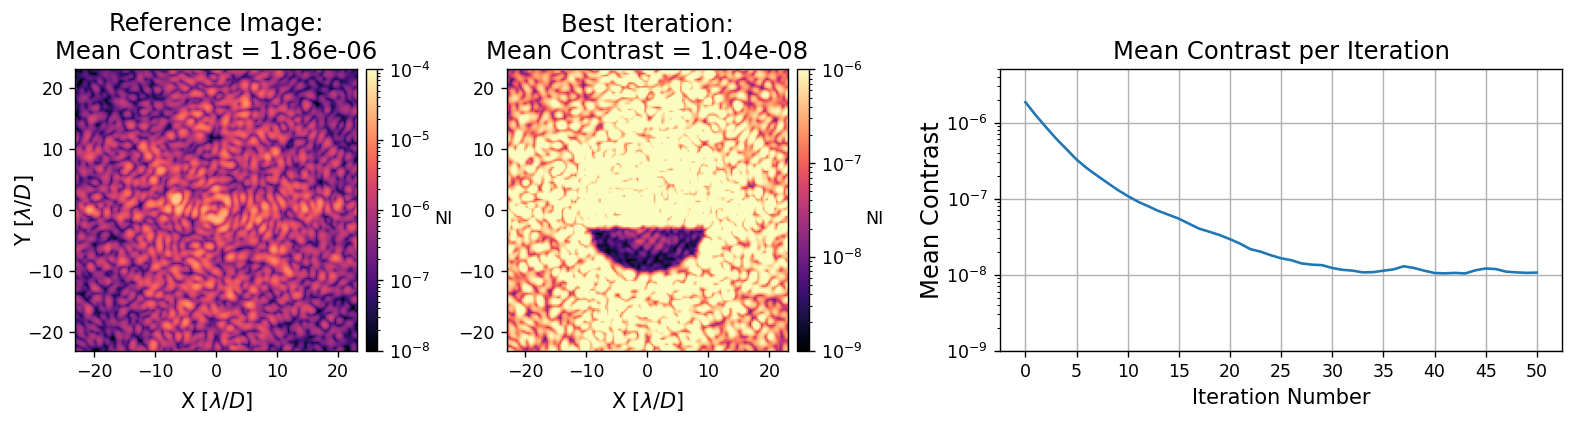

In [12]:
from adefc_vortex import imshows
reload(imshows)

data = utils.load_pickle('data/20250115_scoob_aefc_run.pkl')

imshows.plot_data_with_ref(
    data, 
    im1vmax=1e-4, im1vmin=1e-8, 
    im2vmax=1e-6, im2vmin=1e-9, 
    vmax=5e-6, vmin=1e-9, 
    xticks=np.arange(0, 50+1, 5),
    fname='../figs/scoob_mono_aefc.pdf',
)

In [13]:
data['reg_conds']

[0.01,
 0.01,
 1e-05,
 1e-05,
 0.01,
 0.01,
 1e-06,
 1e-06,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 1e-06,
 1e-06,
 0.1,
 0.1,
 0.001,
 0.001,
 0.1,
 0.1,
 1e-06,
 1e-06,
 0.1,
 0.1,
 0.001,
 0.001,
 1e-07,
 1e-07,
 0.1,
 0.1,
 0.1,
 0.1,
 0.001,
 0.001,
 1e-08,
 1e-08,
 0.1,
 0.1,
 0.1,
 0.01,
 0.01,
 0.01,
 1e-07,
 1e-07,
 0.1,
 0.1,
 0.01,
 0.01,
 0.01]

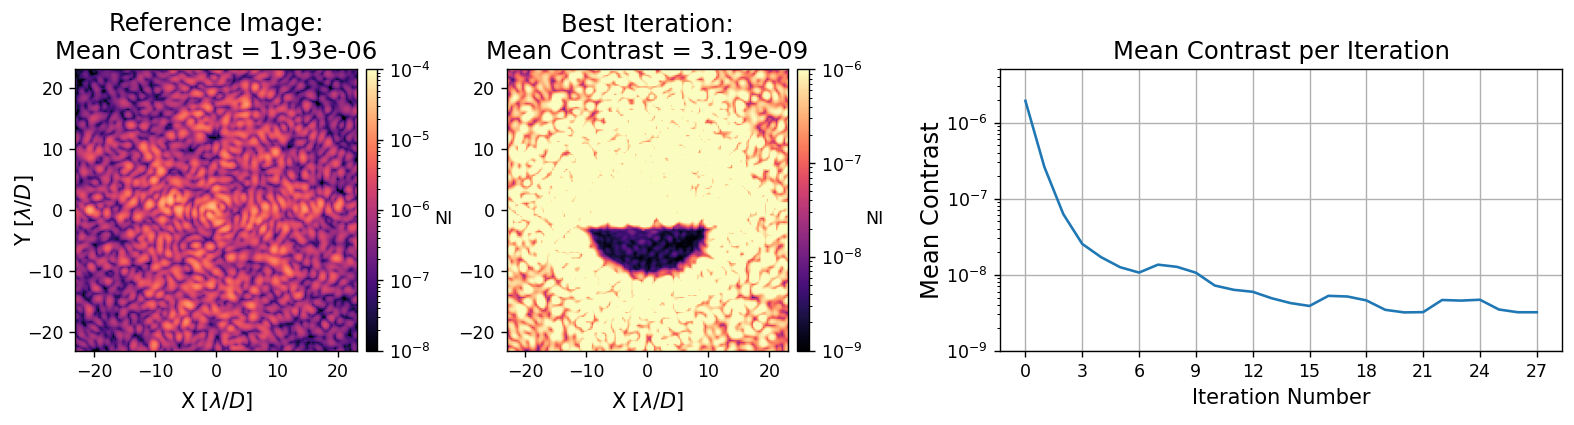

In [9]:
from adefc_vortex import imshows
reload(imshows)

data = utils.load_pickle('data/20250114_iefc_run_1.pkl')
data.update({'control_mask':data['control_mask_2']})

imshows.plot_data_with_ref(
    data, 
    im1vmax=1e-4, im1vmin=1e-8, 
    im2vmax=1e-6, im2vmin=1e-9, 
    vmax=5e-6, vmin=1e-9, 
    xticks=np.arange(0, 27+1, 3),
    fname='../figs/scoob_mono_iefc.pdf',
)

In [4]:
M = scoobm.MODEL()
iwa = 3
owa = 10
rotation = 0
control_mask = utils.create_annular_focal_plane_mask(M.npsf, M.psf_pixelscale_lamDc, iwa, owa, edge=iwa, rotation=rotation)

Oversampling > 2x suggested for reliable results in Fresnel propagation.


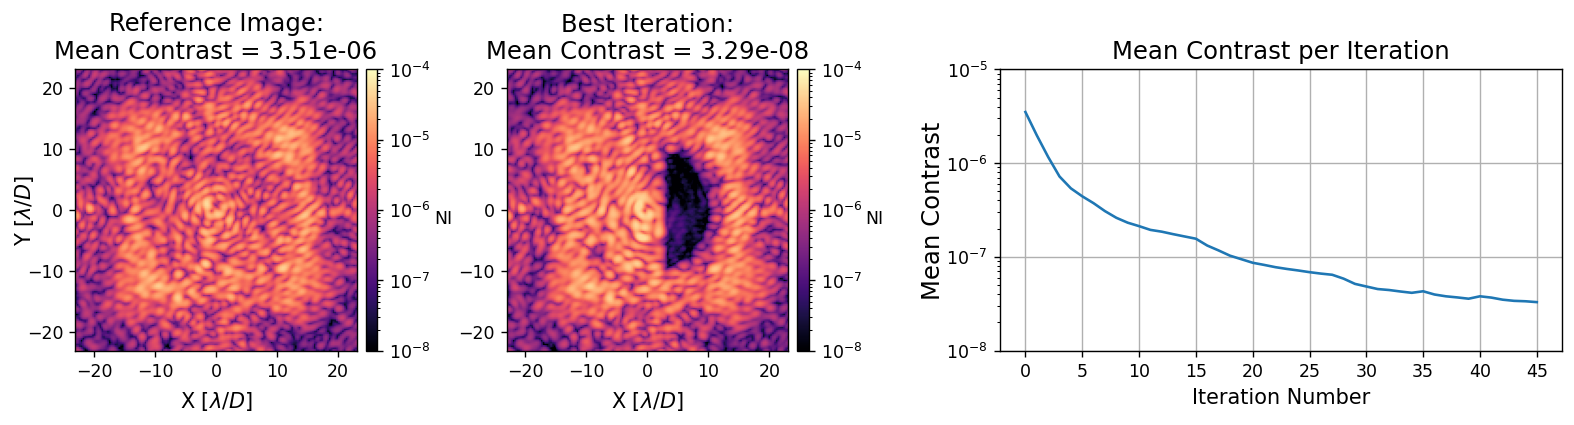

In [11]:
from adefc_vortex import imshows
reload(imshows)

date = 20241029
ref_im = utils.load_fits(f'data/{date}_ref_coro_im.fits')
ims = utils.load_fits(f'data/{date}_adefc_ims.fits')

data = {
    'images':xp.concatenate([xp.array([ref_im]), ims]),
    'control_mask': control_mask,
    'pixelscale':M.psf_pixelscale_lamDc,
}

imshows.plot_data_with_ref(
    data, 
    im1vmax=1e-4, im1vmin=1e-8, 
    im2vmax=1e-4, im2vmin=1e-8, 
    vmax=1e-5, vmin=1e-8, 
    xticks=np.arange(0, 46, 5),
    fname='../figs/scoob_mono_result.pdf',
)


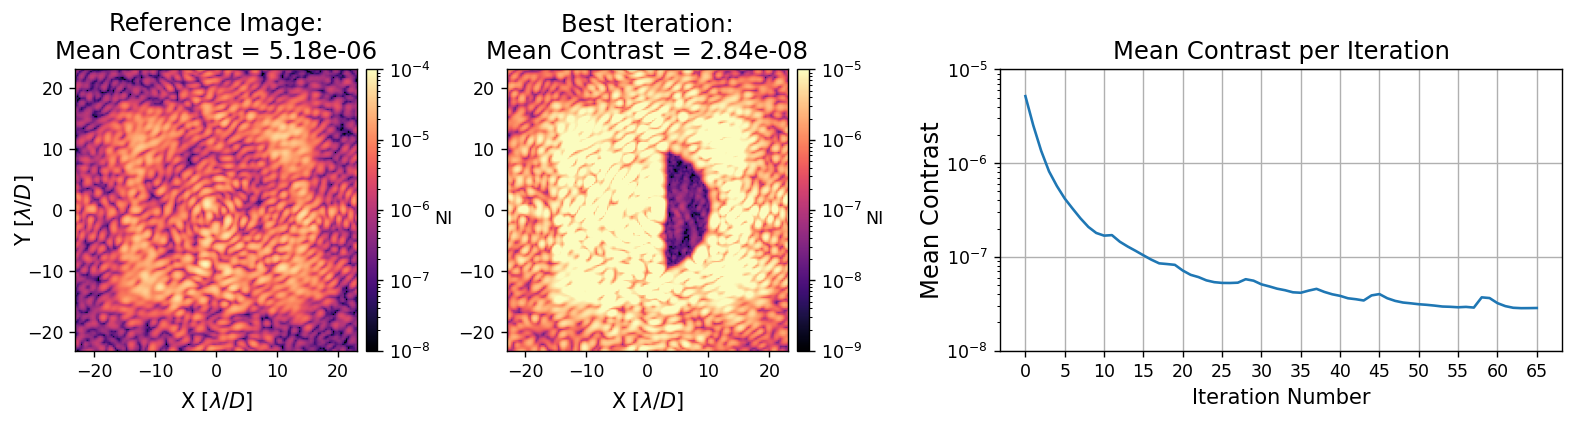

In [4]:
from adefc_vortex import imshows
reload(imshows)

data = utils.load_pickle(f'data/{20241211}_scoob_aefc_run.pkl')

imshows.plot_data_with_ref(
    data, 
    im1vmax=1e-4, im1vmin=1e-8, 
    im2vmax=1e-5, im2vmin=1e-9, 
    vmax=1e-5, vmin=1e-8, 
    xticks=np.arange(0, 65+1, 5),
    fname='../figs/scoob_mono_result.pdf',
)